In [1]:
from base import *
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def gauss_const(x, *p):
    const, A, mu, sigma = p
    return const + A*np.exp(-(x-mu)**2/(2.*sigma**2))

def gauss2(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2 = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))

def gauss2_const(x, *p):
    const, A1, mu1, sigma1, A2, mu2, sigma2 = p
    return const + A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))

def redChiSq(ydata,ymod,std,deg):
    z = (ydata-ymod)/std
    chisq = np.sum(z**2)  
    nu = len(ydata)-deg  
    return chisq/nu

In [2]:
from base import *

No handles with labels found to put in legend.


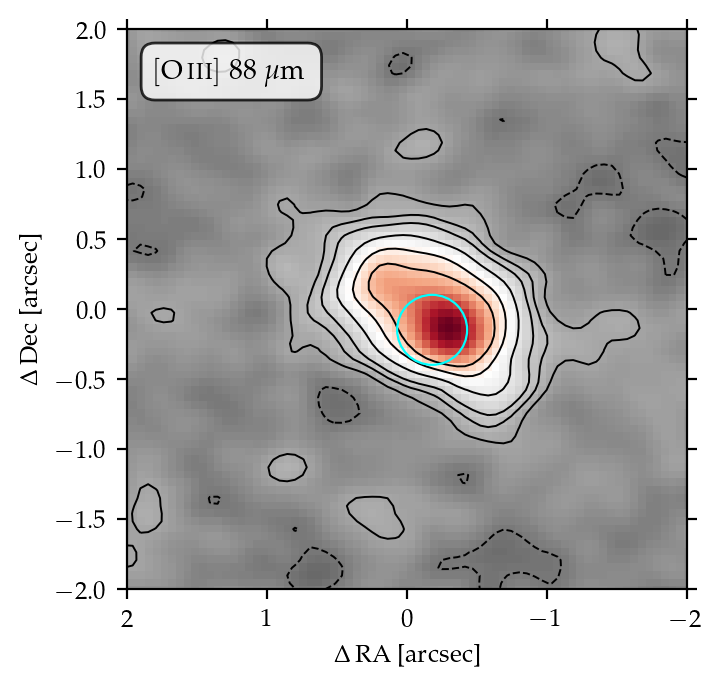

In [3]:
ap = (-0.18,-0.15,0.25)

R = 2
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5))
im = image('OIII','cube','natural_uv0')
nu, flux, flux_err = im.Spectrum(ap)
p = im.aperture_patch
p.set_edgecolor('cyan')
ax.add_patch(p)
im = image('OIII','linemfs','natural_uv0')
ax.imshow(im.data, extent=im.extent, cmap='RdGy_r')
ax.contour(im.data, extent=im.extent, levels=np.array([-2,2,4,6,10,15,20])*im.std, colors='k', linewidths=0.7)
ax.set_xlim(R,-R)
ax.set_ylim(-R,R)
ax.set_xlabel(r'$\Delta\,$RA [arcsec]')
ax.set_ylabel(r'$\Delta\,$Dec [arcsec]')
ax.annotate(r'$[{\rm O}\,\textsc{iii}]~88~\mu$m', (0.05,0.95), xycoords='axes fraction', ha='left', va='top', color='k', fontsize=10, bbox=dict(facecolor='w', edgecolor='k', boxstyle='round,pad=0.5', alpha=0.8))
# ax.scatter([x1],[y1],c='limegreen',marker='+',zorder=1000,s=30,label='Dust Continuum Peak')
# ax.scatter([x2],[y2],c='deepskyblue',marker='x',zorder=1000,s=30,label='UV Continuum Peak')
leg = ax.legend(loc=(0.03, 0.72), fontsize=9)
plt.setp(leg.get_texts(), color='w')
ax.plotBeam(im, (2.6,-2.6))
plt.savefig('OIII_aperture.pdf')
plt.show()


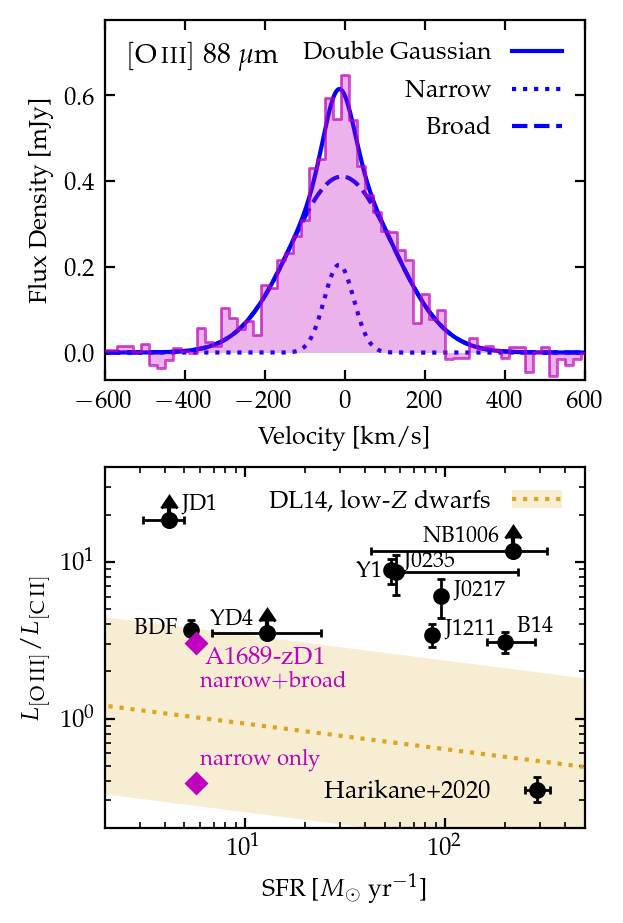

In [28]:

from base import *
x_vel = np.arange(-600,600,1)

fig = plt.figure(figsize=(3,4.5), constrained_layout=True)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=1, figure=fig)
# gs.update(left=0.13, right=0.97, top=0.98, bottom=0.1, hspace=0.05)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax = [ax0,ax1]

im = image('OIII','cube','natural_uv0')
nu, flux, flux_err = im.Spectrum(ap, restfreq=417.2)
std = np.median(flux_err)

### plot data
ax[0].step(nu, flux, color='m', linewidth=1, alpha=0.7, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='m', alpha=0.3, zorder=100)

# fit double gaussian
coeff, var_matrix = curve_fit(gauss2, nu, flux, p0=[1, -50,100, 1, 50, 400],
                              bounds=([0,-800,30,0,-800,30],[np.inf,800,np.inf,np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss2(x_vel, *coeff), color='b', label='Double Gaussian')
ax[0].plot(x_vel, gauss(x_vel, *coeff[:3]), color='b', linestyle=':', label='Narrow')
ax[0].plot(x_vel, gauss(x_vel, *coeff[3:]), color='b', linestyle='--', label='Broad')

ax[0].set_xlim(-600,600)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))

ax[0].set_xlabel('Velocity [km/s]')
ax[0].set_ylabel('Flux Density [mJy]')

ax[0].annotate(r'$[{\rm O}\,\textsc{iii}]~88~\mu$m', (0.05, 0.94), va='top', xycoords='axes fraction', fontsize=10)
leg = ax[0].legend(loc='upper right', markerfirst=False)
leg._legend_box.align = "right"


LOIII_narrow = np.sum(gauss(nu, *coeff[:3]))
LOIII_broad = np.sum(gauss(nu, *coeff[3:]))
im = image('CII','cube','natural_uv0.3')
nu, flux, flux_err = im.Spectrum(ap, restfreq=233.7)
flux[27] = np.nan
LCII = np.nansum(flux)

y_narrow = LOIII_narrow/LCII
y_broad = LOIII_broad/LCII
y_tot = (LOIII_narrow + LOIII_broad) / LCII




import pandas as pd
h2020 = pd.read_csv('Harikane2020.csv')

x = h2020.SFR
y = h2020.LOIII/h2020.LCII
xerr = np.array([h2020.sig_SFR_low,h2020.sig_SFR_up])
yerr = y*np.sqrt((h2020.sig_LOIII/h2020.LOIII)**2 + (h2020.sig_LCII/h2020.LCII)**2)

ax[1].errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='k', mec='k', ecolor='k', label='Harikane+2020')
leg1 = ax[1].legend(loc='lower right', markerfirst=False)

h2020_1 = h2020[h2020.LCII==0]
x = h2020_1.SFR
y = h2020_1.LOIII/(3*h2020_1.sig_LCII)
xerr = np.array([h2020_1.sig_SFR_low,h2020_1.sig_SFR_up])
yerr = y*0.2

ax[1].errorbar(x, y, xerr=xerr, yerr=0, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='k', mec='k', ecolor='k')
ax[1].errorbar(x, y, xerr=0, yerr=yerr, marker='o', elinewidth=1.5, capthick=2, capsize=3, 
            lw=0, ms=5, mew=1, mfc='k', mec='k', ecolor='k', lolims=True)

xrange = np.arange(-4,4,0.2)

### PLOT DE LOOZE+14 RELATION FOR LOW-Z DWARFS
## OIII
yint, slope, disp = -6.71, 0.92, 0.3 # low-Z dwarfs (global)
yint = -yint/slope
slope = 1/slope
log_oiii_exp = slope*xrange+yint
diff_rand = np.zeros((1000,len(xrange)))
for i in range(1000):
    xrange_rand = np.random.normal(loc=xrange, scale=disp)
    diff_rand[i,:] = slope*xrange_rand+yint - log_oiii_exp
log_oiii_exp_disp = np.median(np.std(diff_rand, axis=0))

## CII
yint, slope, disp = -5.73, 0.8, 0.37 # low-Z dwarfs (global)
yint = -yint/slope
slope = 1/slope
log_cii_exp = slope*xrange+yint
diff_rand = np.zeros((1000,len(xrange)))
for i in range(1000):
    xrange_rand = np.random.normal(loc=xrange, scale=disp)
    diff_rand[i,:] = slope*xrange_rand+yint - log_cii_exp
log_cii_exp_disp = np.median(np.std(diff_rand, axis=0))
    
y = log_oiii_exp-log_cii_exp
yerr = np.sqrt(log_oiii_exp_disp**2 + log_cii_exp_disp**2)

dl1, = ax[1].plot(np.power(10., xrange), np.power(10., y), color='goldenrod', linestyle=':')
dl2 = ax[1].fill_between(np.power(10., xrange), np.power(10., y-yerr), np.power(10., y+yerr), ec='none', fc='goldenrod', alpha=0.2, zorder=-1000)

leg2 = ax[1].legend([(dl1,dl2)],['DL14, low-$Z$ dwarfs'], loc='upper right', markerfirst=False)
ax[1].add_artist(leg1)

x = 5.7
x_err = 0.35
y = y_tot
#yerr = y * np.sqrt((np.sqrt(np.sum(LOIII_ap_err**2))/np.sum(LOIII_ap))**2+(np.sqrt(np.sum(LCII_ap_err**2))/np.sum(LCII_ap))**2)
ax[1].errorbar(x, y, xerr=0, yerr=0, marker='D', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='m', mec='m', ecolor='m')

ax[1].annotate("A1689-zD1", (6.3, 2.2), color='m')
ax[1].annotate(r"narrow$+$broad", (6, 1.6), color='m', fontsize=8)

y = y_narrow
ax[1].errorbar(x, y, xerr=0, yerr=0, marker='D', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='m', mec='m', ecolor='m')

ax[1].annotate(r"narrow only", (6, 0.5), color='m', fontsize=8)

ax[1].set_xlim(2, 500)
ax[1].set_ylim(0.2, 40)
ax[1].set_xlabel(r'SFR [$M_\odot~{\rm yr}^{-1}$]')
ax[1].set_ylabel(r'$L_{[\rm {O}\,{\textsc{iii}}]}/L_{[\rm {C}\,{\textsc{ii}}]}$')
ax[1].tick_params(direction='in', which='both')
ax[1].loglog()

ax[1].annotate(h2020.iloc[0].Nickname, (h2020.iloc[0].SFR*1.15, h2020.iloc[0].LOIII/(3*h2020.iloc[0].sig_LCII)*1.15), fontsize=8)
ax[1].annotate(h2020.iloc[1].Nickname, (h2020.iloc[1].SFR*0.85, h2020.iloc[1].LOIII/(3*h2020.iloc[1].sig_LCII)*1.12), ha='right', fontsize=8)
ax[1].annotate(h2020.iloc[2].Nickname, (h2020.iloc[2].SFR*0.85, h2020.iloc[2].LOIII/(h2020.iloc[2].LCII)*1.0), ha='right', va='center', fontsize=8)
ax[1].annotate(h2020.iloc[3].Nickname, (h2020.iloc[3].SFR*0.85, h2020.iloc[3].LOIII/(3*h2020.iloc[3].sig_LCII)*1.12), ha='right', fontsize=8)
ax[1].annotate(h2020.iloc[4].Nickname, (h2020.iloc[4].SFR*1.15, h2020.iloc[4].LOIII/(h2020.iloc[4].LCII)*1.15), fontsize=8)
ax[1].annotate(h2020.iloc[5].Nickname, (h2020.iloc[5].SFR*0.85, h2020.iloc[5].LOIII/(h2020.iloc[5].LCII)), ha='right', va='center', fontsize=8)
ax[1].annotate(h2020.iloc[6].Nickname, (h2020.iloc[6].SFR*1.15, h2020.iloc[6].LOIII/(h2020.iloc[6].LCII)*1.0), fontsize=8)
ax[1].annotate(h2020.iloc[7].Nickname, (h2020.iloc[7].SFR*1.15, h2020.iloc[7].LOIII/(h2020.iloc[7].LCII)*1.05), fontsize=8)
ax[1].annotate(h2020.iloc[8].Nickname, (h2020.iloc[8].SFR*1.15, h2020.iloc[8].LOIII/(h2020.iloc[8].LCII)*1.0), fontsize=8)

ax[0].tick_params(direction='in', which='both')
ax[1].tick_params(direction='in', which='both')

plt.savefig('LOIII_LCII_outflow.pdf')
plt.show()

In [16]:
y_tot

3.0552392398094868

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3, 2.6))

import pandas as pd
h2020 = pd.read_csv('Harikane2020.csv')

x = h2020.SFR
y = h2020.LOIII/h2020.LCII
xerr = np.array([h2020.sig_SFR_low,h2020.sig_SFR_up])
yerr = y*np.sqrt((h2020.sig_LOIII/h2020.LOIII)**2 + (h2020.sig_LCII/h2020.LCII)**2)

ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='k', mec='k', ecolor='k', label='Harikane+2020')
leg1 = ax.legend(loc='lower left')

h2020_1 = h2020[h2020.LCII==0]
x = h2020_1.SFR
y = h2020_1.LOIII/(3*h2020_1.sig_LCII)
xerr = np.array([h2020_1.sig_SFR_low,h2020_1.sig_SFR_up])
yerr = y*0.2

ax.errorbar(x, y, xerr=xerr, yerr=0, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='k', mec='k', ecolor='k')
ax.errorbar(x, y, xerr=0, yerr=yerr, marker='o', elinewidth=1.5, capthick=2, capsize=3, 
            lw=0, ms=5, mew=1, mfc='k', mec='k', ecolor='k', lolims=True)

    
### PLOT DE LOOZE+14 RELATION FOR LOW-Z DWARFS
## OIII
yint, slope, disp = -6.71, 0.92, 0.3 # low-Z dwarfs (global)
yint = -yint/slope
slope = 1/slope
log_oiii_exp = slope*xrange+yint
diff_rand = np.zeros((1000,len(xrange)))
for i in range(1000):
    xrange_rand = np.random.normal(loc=xrange, scale=disp)
    diff_rand[i,:] = slope*xrange_rand+yint - log_oiii_exp
log_oiii_exp_disp = np.median(np.std(diff_rand, axis=0))

## CII
yint, slope, disp = -5.73, 0.8, 0.37 # low-Z dwarfs (global)
yint = -yint/slope
slope = 1/slope
log_cii_exp = slope*xrange+yint
diff_rand = np.zeros((1000,len(xrange)))
for i in range(1000):
    xrange_rand = np.random.normal(loc=xrange, scale=disp)
    diff_rand[i,:] = slope*xrange_rand+yint - log_cii_exp
log_cii_exp_disp = np.median(np.std(diff_rand, axis=0))
    
y = log_oiii_exp-log_cii_exp
yerr = np.sqrt(log_oiii_exp_disp**2 + log_cii_exp_disp**2)

dl1, = ax.plot(np.power(10., xrange), np.power(10., y), color='goldenrod', linestyle=':')
dl2 = ax.fill_between(np.power(10., xrange), np.power(10., y-yerr), np.power(10., y+yerr), ec='none', fc='goldenrod', alpha=0.2, zorder=-1000)


# ### PLOT DE LOOZE+14 RELATION FOR HII/starburst
# ## OIII
# yint, slope, disp = -3.89, 0.69, 0.23 
# yint = -yint/slope
# slope = 1/slope
# log_oiii_exp = slope*xrange+yint
# diff_rand = np.zeros((1000,len(xrange)))
# for i in range(1000):
#     xrange_rand = np.random.normal(loc=xrange, scale=disp)
#     diff_rand[i,:] = slope*xrange_rand+yint - log_oiii_exp
# log_oiii_exp_disp = np.median(np.std(diff_rand, axis=0))

# ## CII
# yint, slope, disp = -7.06, 1.0, 0.27 
# yint = -yint/slope
# slope = 1/slope
# log_cii_exp = slope*xrange+yint
# diff_rand = np.zeros((1000,len(xrange)))
# for i in range(1000):
#     xrange_rand = np.random.normal(loc=xrange, scale=disp)
#     diff_rand[i,:] = slope*xrange_rand+yint - log_cii_exp
# log_cii_exp_disp = np.median(np.std(diff_rand, axis=0))
    
# y = log_oiii_exp-log_cii_exp
# yerr = np.sqrt(log_oiii_exp_disp**2 + log_cii_exp_disp**2)

# dl3, = ax.plot(np.power(10., xrange), np.power(10., y), color='skyblue', linestyle=':')
# dl4 = ax.fill_between(np.power(10., xrange), np.power(10., y-yerr), np.power(10., y+yerr), ec='none', fc='skyblue', alpha=0.2, zorder=-1000)


# leg2 = ax.legend([(dl1,dl2),(dl3,dl4)],['DL14, low-$Z$ dwarfs','DL14, HII/starburst'], loc='upper right')
leg2 = ax.legend([(dl1,dl2)],['DL14, low-$Z$ dwarfs'], loc='upper right')
ax.add_artist(leg1)

x = np.sum(SFR_ap)
xerr = np.sqrt(np.sum(SFR_ap_err**2))
y = np.sum(LOIII_ap)/np.sum(LCII_ap)
yerr = y * np.sqrt((np.sqrt(np.sum(LOIII_ap_err**2))/np.sum(LOIII_ap))**2+(np.sqrt(np.sum(LCII_ap_err**2))/np.sum(LCII_ap))**2)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='r', mec='r', ecolor='r')

ax.annotate("A1689-zD1 \n", (12, 4), color='r')
ax.annotate(r"$< 3.5''$", (x*1.07, y*1.05), color='r', fontsize=8)


x = np.sum(SFR_ap[:3])
xerr = np.sqrt(np.sum(SFR_ap_err[:3]**2))
y = np.sum(LOIII_ap[:3])/np.sum(LCII_ap[:3])
yerr = y * np.sqrt((np.sqrt(np.sum(LOIII_ap_err[:3]**2))/np.sum(LOIII_ap[:3]))**2+(np.sqrt(np.sum(LCII_ap_err[:3]**2))/np.sum(LCII_ap[:3]))**2)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='r', mec='r', ecolor='r')

ax.annotate(r"$< 0.75''$", (x*1.07, y*1.05), color='r', fontsize=8)

x = np.sum(SFR_ap[:2])
xerr = np.sqrt(np.sum(SFR_ap_err[:2]**2))
y = np.sum(LOIII_ap[:2])/np.sum(LCII_ap[:2])
yerr = y * np.sqrt((np.sqrt(np.sum(LOIII_ap_err[:2]**2))/np.sum(LOIII_ap[:2]))**2+(np.sqrt(np.sum(LCII_ap_err[:2]**2))/np.sum(LCII_ap[:2]))**2)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', elinewidth=1, capthick=1, capsize=1.3, 
            lw=0, ms=5, mew=1, mfc='r', mec='r', ecolor='r')


ax.annotate(r"$< 0.5''$", (x*1.07, y*1.05), color='r', fontsize=8)



ax.set_xlim(2, 500)
ax.set_ylim(0.3, 40)
ax.set_xlabel(r'SFR [$M_\odot~{\rm yr}^{-1}$]')
ax.set_ylabel(r'$L_{[\rm {O}\,{\textsc{iii}}]}/L_{[\rm {C}\,{\textsc{ii}}]}$')
ax.tick_params(direction='in', which='both')
ax.loglog()

ax.annotate(h2020.iloc[0].Nickname, (h2020.iloc[0].SFR*1.15, h2020.iloc[0].LOIII/(3*h2020.iloc[0].sig_LCII)*1.15), fontsize=8)
ax.annotate(h2020.iloc[1].Nickname, (h2020.iloc[1].SFR*0.85, h2020.iloc[1].LOIII/(3*h2020.iloc[1].sig_LCII)*1.12), ha='right', fontsize=8)
ax.annotate(h2020.iloc[2].Nickname, (h2020.iloc[2].SFR*0.85, h2020.iloc[2].LOIII/(h2020.iloc[2].LCII)*1.0), ha='right', va='center', fontsize=8)
ax.annotate(h2020.iloc[3].Nickname, (h2020.iloc[3].SFR*0.85, h2020.iloc[3].LOIII/(3*h2020.iloc[3].sig_LCII)*1.12), ha='right', fontsize=8)
ax.annotate(h2020.iloc[4].Nickname, (h2020.iloc[4].SFR*1.15, h2020.iloc[4].LOIII/(h2020.iloc[4].LCII)*1.15), fontsize=8)
ax.annotate(h2020.iloc[5].Nickname, (h2020.iloc[5].SFR*0.85, h2020.iloc[5].LOIII/(h2020.iloc[5].LCII)), ha='right', va='center', fontsize=8)
ax.annotate(h2020.iloc[6].Nickname, (h2020.iloc[6].SFR*1.15, h2020.iloc[6].LOIII/(h2020.iloc[6].LCII)*1.0), fontsize=8)
ax.annotate(h2020.iloc[7].Nickname, (h2020.iloc[7].SFR*1.15, h2020.iloc[7].LOIII/(h2020.iloc[7].LCII)*1.05), fontsize=8)
ax.annotate(h2020.iloc[8].Nickname, (h2020.iloc[8].SFR*1.15, h2020.iloc[8].LOIII/(h2020.iloc[8].LCII)*1.0), fontsize=8)


plt.savefig('LOIII_LCII_Harikane.pdf')
plt.show()

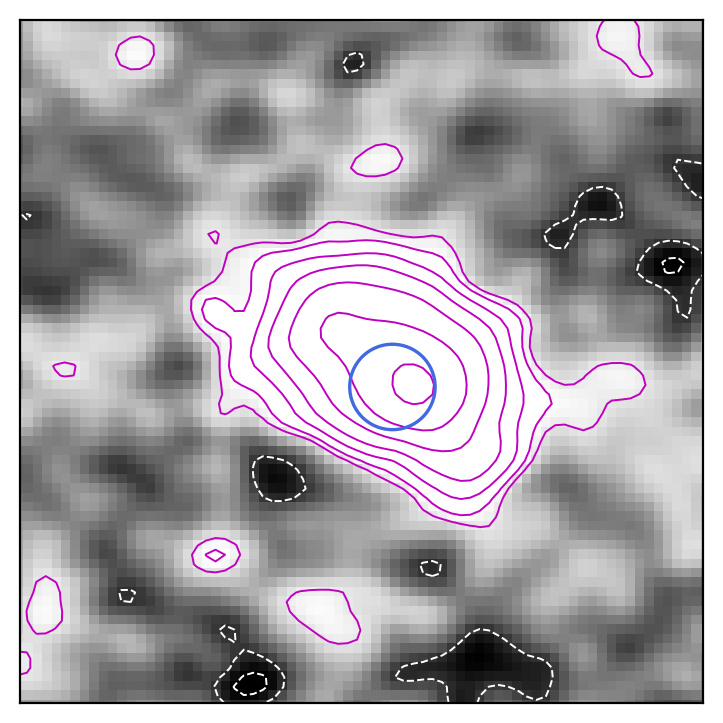

In [6]:
# central UV and IR-bright clump
R = 2

fig, ax = plt.subplots(1,1, figsize=(3.5,3.5))
im = image('OIII','cube','natural_uv0')
nu, flux, flux_err = im.Spectrum(ap)
p = im.aperture_patch
p.set_edgecolor('royalblue')
p.set_linewidth('1.2')
ax.add_patch(p)
im = image('OIII','linemfs','natural_uv0')
ax.imshow(im.data/im.std_map, extent=im.extent, cmap='Greys_r', vmin=-3, vmax=3)
ax.contour(im.data/im.std_map, extent=im.extent, levels=[-3,-2], colors='w', linewidths=0.7)
ax.contour(im.data/im.std_map, extent=im.extent, levels=[2,3,5,8,13,21,34,55], colors='m', linewidths=0.7)
ax.set_xlim(R,-R)
ax.set_ylim(-R,R)
ax.plotBeam(im, (2.6,-2.6))
ax.tick_params(labelleft=False,labelbottom=False,left=False,right=False,top=False,bottom=False)
plt.savefig('OIII_aperture.pdf')
plt.show()


From nu = -398.5 to nu = -198.5, single gaussian residual shows S/N of 0.48
From nu = 201.6 to nu = 401.6, single gaussian residual shows S/N of 0.25


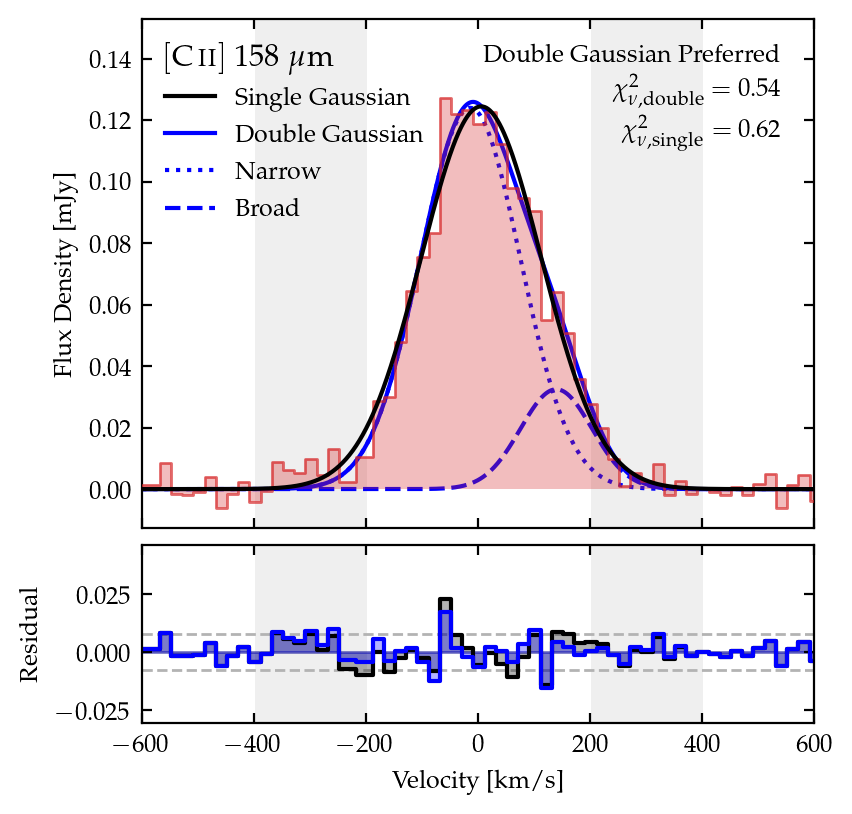

In [28]:

from base import *
x_vel = np.arange(-600,600,1)

fig = plt.figure(figsize=(4,4), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1,0.35])
gs.update(left=0.13, right=0.97, top=0.98, bottom=0.1, hspace=0.05)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax = [ax0,ax1]

im = image('CII','cube','natural_uv0.3')
nu, flux, flux_err = im.Spectrum(ap, restfreq=233.7)

flux[27] = np.nan
flux_err[27] = np.nan
nu[27] = np.nan
nu = nu[~np.isnan(nu)]
flux = flux[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux_err)]

std = np.median(flux_err)

### fit single gaussian
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[1, 0, 100], bounds=([0,-800,0],[np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss(x_vel, *coeff), color='k', label='Single Gaussian', zorder=102)
chi_single = redChiSq(flux, gauss(nu, *coeff), std, len(coeff))
ax[1].step(nu, flux - gauss(nu, *coeff), color='k', where='mid')
ax[1].fill_between(nu, flux - gauss(nu, *coeff), color='k', step='mid', alpha=0.3)

### plot data
ax[0].step(nu, flux, color='tab:red', linewidth=1, alpha=0.7, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='tab:red', alpha=0.3, zorder=100)


res = flux - gauss(nu, *coeff)
imin, imax = 18, 28
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}')
imin, imax = 47, 58
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}')



# fit double gaussian
coeff, var_matrix = curve_fit(gauss2, nu, flux, p0=[1, -50,100, 1, 50, 200],
                              bounds=([0,-800,30,0,-800,30],[np.inf,800,np.inf,np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss2(x_vel, *coeff), color='b', label='Double Gaussian')
ax[0].plot(x_vel, gauss(x_vel, *coeff[:3]), color='b', linestyle=':', label='Narrow')
ax[0].plot(x_vel, gauss(x_vel, *coeff[3:]), color='b', linestyle='--', label='Broad')
chi_double = redChiSq(flux, gauss2(nu, *coeff), std, len(coeff))
ax[1].step(nu, flux - gauss2(nu, *coeff), color='b', where='mid')
ax[1].fill_between(nu, flux - gauss2(nu, *coeff), color='b', step='mid', alpha=0.3)

# compute chi^2 values
if chi_double < chi_single:
    ax[0].annotate(f'Double Gaussian Preferred \n' + r'$\chi^2_{\nu,{\rm double}} = $'+f' {chi_double:.2f}' + '\n' +  r'$\chi^2_{\nu,{\rm single}} = $'+f' {chi_single:.2f}', 
                   (0.95,0.95), xycoords='axes fraction', va='top', ha='right')
else:
    ax[0].annotate(f'Single Gaussian Preferred \n' + r'$\chi^2_{\nu,{\rm double}} = $'+f' {chi_double:.2f}' + '\n' +  r'$\chi^2_{\nu,{\rm single}} = $'+f' {chi_single:.2f}', 
                   (0.95,0.95), xycoords='axes fraction', va='top', ha='right')


ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-600,600)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-600,600)
ax[1].set_ylim(-4*std, 6*std)
ax[1].set_xlabel('Velocity [km/s]')
ax[0].set_ylabel('Flux Density [mJy]')
ax[1].set_ylabel('Residual')
leg = ax[0].legend(loc='upper left', title=r'$[{\rm C}\,\textsc{ii}]~158~\mu$m')
leg._legend_box.align = "left"
leg.get_title().set_fontsize('11')
ax[0].tick_params(direction='in', which='both', labelbottom=False)
ax[1].tick_params(direction='in', which='both')

plt.savefig('CII_central_region_line_profile.pdf')
plt.show()

From nu = -395.2 to nu = -195.2, single gaussian residual shows S/N of 0.66
From nu = 204.9 to nu = 404.9, single gaussian residual shows S/N of 0.04
From nu = -400.0 to nu = -200.0, single gaussian residual shows S/N of 2.35
From nu = 200.0 to nu = 400.0, single gaussian residual shows S/N of 1.09


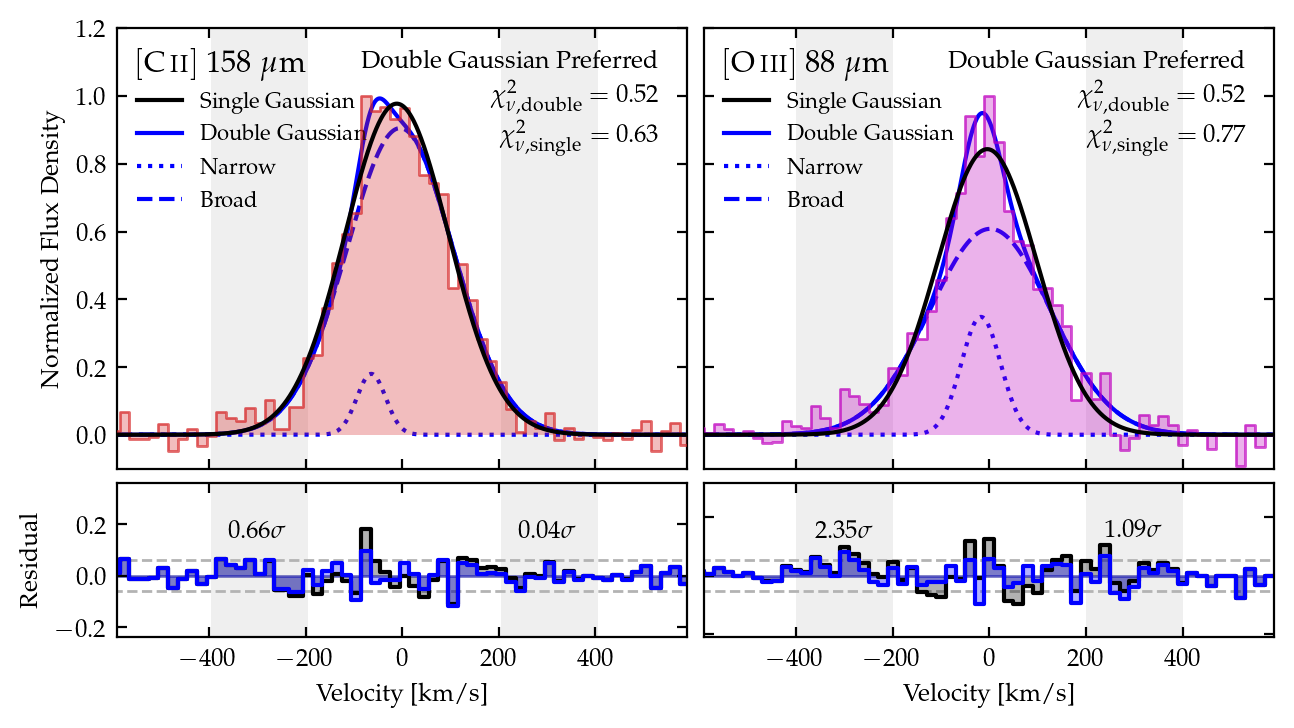

In [123]:

from base import *
x_vel = np.arange(-600,600,1)

fig = plt.figure(figsize=(6.5,3.5), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,0.35])
gs.update(left=0.1, right=0.99, top=0.98, bottom=0.11, hspace=0.05, wspace=0.03)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax = [ax0,ax1]

im = image('CII','cube','natural_uv0.3')
nu, flux, flux_err = im.Spectrum(ap, restfreq=233.687)

nu[27] = np.nan
flux = flux[~np.isnan(nu)]
flux_err = flux_err[~np.isnan(nu)]
nu = nu[~np.isnan(nu)]
flux_err /= np.max(flux)
flux /= np.max(flux)
std = np.median(flux_err)

### fit single gaussian
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[1, 0, 100], bounds=([0,-800,0],[np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss(x_vel, *coeff), color='k', label='Single Gaussian', zorder=102)
chi_single = redChiSq(flux, gauss(nu, *coeff), std, len(coeff))
ax[1].step(nu, flux - gauss(nu, *coeff), color='k', where='mid')
ax[1].fill_between(nu, flux - gauss(nu, *coeff), color='k', step='mid', alpha=0.3)

### plot data
ax[0].step(nu, flux, color='tab:red', linewidth=1, alpha=0.7, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='tab:red', alpha=0.3, zorder=100)

res = flux - gauss(nu, *coeff)
imin, imax = 19, 29
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (-300,2.5*std), ha='center')

imin, imax = 48, 59
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (300,2.5*std), ha='center')

# fit double gaussian
coeff, var_matrix = curve_fit(gauss2, nu, flux, p0=[1, -50,100, 1, 50, 200],
                              bounds=([0,-800,30,0,-800,30],[np.inf,800,np.inf,np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss2(x_vel, *coeff), color='b', label='Double Gaussian')
ax[0].plot(x_vel, gauss(x_vel, *coeff[:3]), color='b', linestyle=':', label='Narrow')
ax[0].plot(x_vel, gauss(x_vel, *coeff[3:]), color='b', linestyle='--', label='Broad')
chi_double = redChiSq(flux, gauss2(nu, *coeff), std, len(coeff))
ax[1].step(nu, flux - gauss2(nu, *coeff), color='b', where='mid')
ax[1].fill_between(nu, flux - gauss2(nu, *coeff), color='b', step='mid', alpha=0.3)

# compute chi^2 values
if chi_double < chi_single:
    ax[0].annotate(f'Double Gaussian Preferred \n' + r'$\chi^2_{\nu,{\rm double}} = $'+f' {chi_double:.2f}' + '\n' +  r'$\chi^2_{\nu,{\rm single}} = $'+f' {chi_single:.2f}', 
                   (0.95,0.95), xycoords='axes fraction', va='top', ha='right')
else:
    ax[0].annotate(f'Single Gaussian Preferred \n' + r'$\chi^2_{\nu,{\rm double}} = $'+f' {chi_double:.2f}' + '\n' +  r'$\chi^2_{\nu,{\rm single}} = $'+f' {chi_single:.2f}', 
                   (0.95,0.95), xycoords='axes fraction', va='top', ha='right')


ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-590,590)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-590,590)
ax[1].set_ylim(-4*std, 6*std)
ax[1].set_xlabel('Velocity [km/s]')
ax[0].set_ylabel('Normalized Flux Density')
ax[1].set_ylabel('Residual')
leg = ax[0].legend(loc='upper left', title=r'$[{\rm C}\,\textsc{ii}]~158~\mu$m', fontsize=8)
leg._legend_box.align = "left"
leg.get_title().set_fontsize('11')
ax[0].tick_params(direction='in', which='both', labelbottom=False)
ax[1].tick_params(direction='in', which='both')


ax0 = plt.subplot(gs[0,1])
ax1 = plt.subplot(gs[1,1])
ax = [ax0,ax1]

im = image('OIII','cube','natural_uv0')
nu, flux, flux_err = im.Spectrum(ap, restfreq=417.2)

flux_err /= np.max(flux)
flux /= np.max(flux)
std = np.median(flux_err)

### fit single gaussian
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[1, 0, 100], bounds=([0,-800,0],[np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss(x_vel, *coeff), color='k', label='Single Gaussian', zorder=102)
chi_single = redChiSq(flux, gauss(nu, *coeff), std, len(coeff))
ax[1].step(nu, flux - gauss(nu, *coeff), color='k', where='mid')
ax[1].fill_between(nu, flux - gauss(nu, *coeff), color='k', step='mid', alpha=0.3)

### plot data
ax[0].step(nu, flux, color='m', linewidth=1, alpha=0.7, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='m', alpha=0.3, zorder=100)

res = flux - gauss(nu, *coeff)
imin, imax = 16, 27
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (-300,2.5*std), ha='center')
imin, imax = 46, 57
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.2, zorder=-10)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (300,2.5*std), ha='center')


# fit double gaussian
coeff, var_matrix = curve_fit(gauss2, nu, flux, p0=[1, -50,100, 1, 50, 400],
                              bounds=([0,-800,30,0,-800,30],[np.inf,800,np.inf,np.inf,800,np.inf]))
ax[0].plot(x_vel, gauss2(x_vel, *coeff), color='b', label='Double Gaussian')
ax[0].plot(x_vel, gauss(x_vel, *coeff[:3]), color='b', linestyle=':', label='Narrow')
ax[0].plot(x_vel, gauss(x_vel, *coeff[3:]), color='b', linestyle='--', label='Broad')
chi_double = redChiSq(flux, gauss2(nu, *coeff), std, len(coeff))
ax[1].step(nu, flux - gauss2(nu, *coeff), color='b', where='mid')
ax[1].fill_between(nu, flux - gauss2(nu, *coeff), color='b', step='mid', alpha=0.3)

# compute chi^2 values
if chi_double < chi_single:
    ax[0].annotate(f'Double Gaussian Preferred \n' + r'$\chi^2_{\nu,{\rm double}} = $'+f' {chi_double:.2f}' + '\n' +  r'$\chi^2_{\nu,{\rm single}} = $'+f' {chi_single:.2f}', 
                   (0.95,0.95), xycoords='axes fraction', va='top', ha='right')
else:
    ax[0].annotate(f'Single Gaussian Preferred \n' + r'$\chi^2_{\nu,{\rm double}} = $'+f' {chi_double:.2f}' + '\n' +  r'$\chi^2_{\nu,{\rm single}} = $'+f' {chi_single:.2f}', 
                   (0.95,0.95), xycoords='axes fraction', va='top', ha='right')


ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-590,590)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-590,590)
ax[1].set_ylim(-4*std, 6*std)
ax[1].set_xlabel('Velocity [km/s]')
# ax[0].set_ylabel('Flux Density [mJy]')
# ax[1].set_ylabel('Residual')
leg = ax[0].legend(loc='upper left', title=r'$[{\rm O}\,\textsc{iii}]~88~\mu$m', fontsize=8)
leg._legend_box.align = "left"
leg.get_title().set_fontsize('11')
ax[0].tick_params(direction='in', which='both', labelbottom=False, labelleft=False)
ax[1].tick_params(direction='in', which='both', labelleft=False)

plt.savefig('line_profiles.pdf')
plt.show()

In [44]:
flux[31]/np.max(flux)

0.5071427608348729

In [5]:
def calc_FWHM(nu, flux):
    x = np.array([np.max(nu[(flux < 0.5*np.max(flux))&(nu < 0)]), np.min(nu[(flux > 0.5*np.max(flux))&(nu < 0)])])
    y = np.array([flux[nu==n][0] for n in x])/np.max(flux)
    x_interp = np.arange(-400,400,0.1)
    y_interp = np.interp(x_interp, np.sort(x), y[np.argsort(x)])
    nu_min = x_interp[np.argmin(np.abs(y_interp-0.5))]

    x = np.array([np.min(nu[(flux < 0.5*np.max(flux))&(nu > 0)]), np.max(nu[(flux > 0.5*np.max(flux))&(nu > 0)])])
    y = np.array([flux[nu==n][0] for n in x])/np.max(flux)
    x_interp = np.arange(-400,400,0.1)
    y_interp = np.interp(x_interp, np.sort(x), y[np.argsort(x)])
    nu_max = x_interp[np.argmin(np.abs(y_interp-0.5))]
    return nu_max-nu_min

def calc_FWHM_err(nu, flux, flux_err, N=5000):
    FWHMs = np.zeros(N)
    np.random.seed(132)
    for i in range(N):
        f = np.random.normal(loc=flux, scale=flux_err)
        FWHMs[i] = calc_FWHM(nu, f)
        
    return np.median(FWHMs), np.std(FWHMs)

def gauss(x, mu):
    global FWHM
    sigma = FWHM/2.355
    return np.exp(-(x-mu)**2/(2.*sigma**2))


CII Reduced ChiSq: 1.177
From nu = -395.2 to nu = -95.2, single gaussian residual shows S/N of -0.77
From nu = 104.9 to nu = 404.9, single gaussian residual shows S/N of 1.46
Combined, wing residual shows S/N of 0.51
OIII Reduced ChiSq: 2.158
From nu = -400.0 to nu = -100.0, single gaussian residual shows S/N of 5.61
From nu = 100.0 to nu = 400.0, single gaussian residual shows S/N of 5.30
Combined, wing residual shows S/N of 7.71


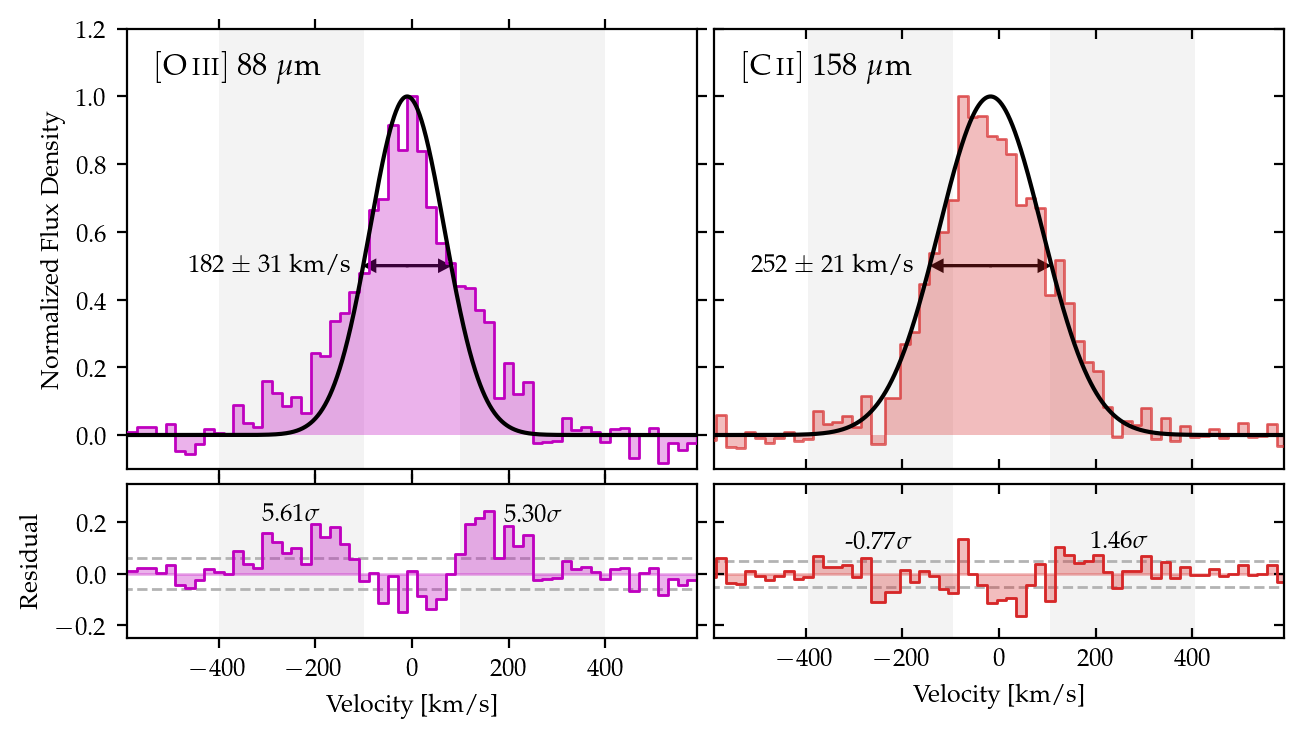

In [7]:

from base import *
x_vel = np.arange(-600,600,1)

fig = plt.figure(figsize=(6.5,3.5), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,0.35])
gs.update(left=0.1, right=0.99, top=0.98, bottom=0.11, hspace=0.05, wspace=0.03)
ax0 = plt.subplot(gs[0,1])
ax1 = plt.subplot(gs[1,1])
ax = [ax0,ax1]

im = image('CII','cube','natural_uv0.3')
nu, flux, flux_err = im.Spectrum(ap, restfreq=233.687)

nu[27] = np.nan
flux = flux[~np.isnan(nu)]
flux_err = flux_err[~np.isnan(nu)]
nu = nu[~np.isnan(nu)]
flux_err /= np.max(flux)
flux /= np.max(flux)
std = np.median(flux_err)

### plot data
ax[0].step(nu, flux, color='tab:red', linewidth=1, alpha=0.7, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='tab:red', alpha=0.3, zorder=100)

### fit single gaussian
FWHM, FWHM_err = calc_FWHM_err(nu,flux, flux_err, N=5000)
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[0])
print(f'CII Reduced ChiSq: {redChiSq(flux, gauss(nu, *coeff), np.median(flux_err), len(coeff)):.3f}')
ax[0].plot(x_vel, gauss(x_vel, coeff), color='k', zorder=102)
res = flux - gauss(nu, coeff)
ax[1].step(nu, res, color='tab:red', where='mid', linewidth=1)
ax[1].fill_between(nu, res, color='tab:red', step='mid', alpha=0.3)

ax[0].annotate(fr'{FWHM:.0f} $\pm$ {FWHM_err:.0f} km/s', (coeff[0]-FWHM/1.6, 0.5), ha='right', va='center')
ax[0].arrow(coeff[0], 0.5, -FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)
ax[0].arrow(coeff[0], 0.5, FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)

numin, numax = -400, -100
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S1, N1 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S1/N1:.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (-250,2*std), ha='center')

numin, numax = 100, 400
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S2, N2 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S2/N2:.2f}')
print(f'Combined, wing residual shows S/N of {(S1+S2)/np.sqrt(N1**2+N2**2):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (250,2*std), ha='center')

ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-590,590)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-590,590)
ax[1].set_ylim(-4*std, 6*std)
ax[1].set_xlabel('Velocity [km/s]')
ax[0].annotate(r'$[{\rm C}\,\textsc{ii}]~158~\mu$m', (0.05,0.95), xycoords='axes fraction', va='top', fontsize=11)
leg._legend_box.align = "left"
leg.get_title().set_fontsize('11')
ax[0].tick_params(direction='in', which='both', labelbottom=False)
ax[1].tick_params(direction='in', which='both')
ax[1].set_ylim(-0.25, 0.35)
ax[1].tick_params(direction='in', which='both', labelleft=False)
ax[0].tick_params(direction='in', which='both', labelbottom=False, labelleft=False)

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax = [ax0,ax1]

im = image('OIII','cube','natural_uv0')
nu, flux, flux_err = im.Spectrum(ap, restfreq=417.2)

flux_err /= np.max(flux)
flux /= np.max(flux)
std = np.median(flux_err)

### plot data
ax[0].step(nu, flux, color='m', linewidth=1, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='m', alpha=0.3, zorder=100)

### fit single gaussian
FWHM, FWHM_err = calc_FWHM_err(nu,flux, flux_err, N=5000)
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[0])
print(f'OIII Reduced ChiSq: {redChiSq(flux, gauss(nu, *coeff), np.median(flux_err), len(coeff)):.3f}')

ax[0].plot(x_vel, gauss(x_vel, coeff), color='k', zorder=102)
res = flux - gauss(nu, coeff)
ax[1].step(nu, res, color='m', where='mid', linewidth=1)
ax[1].fill_between(nu, res, color='m', step='mid', alpha=0.3)

ax[0].annotate(fr'{FWHM:.0f} $\pm$ {FWHM_err:.0f} km/s', (coeff[0]-FWHM/1.6, 0.5), ha='right', va='center')
ax[0].arrow(coeff[0], 0.5, -FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)
ax[0].arrow(coeff[0], 0.5, FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)

numin, numax = -400, -100
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S1, N1 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S1/N1:.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (-250,3.5*std), ha='center')

numin, numax = 100, 400
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S2, N2 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S2/N2:.2f}')
print(f'Combined, wing residual shows S/N of {(S1+S2)/np.sqrt(N1**2+N2**2):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (250,3.5*std), ha='center')


ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-590,590)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-590,590)
ax[1].set_ylim(-0.25, 0.35)
ax[1].set_xlabel('Velocity [km/s]')
ax[0].set_ylabel('Normalized Flux Density')
ax[1].set_ylabel('Residual')
ax[0].annotate(r'$[{\rm O}\,\textsc{iii}]~88~\mu$m', (0.05,0.95), xycoords='axes fraction', va='top', fontsize=11)

plt.savefig('line_profiles_fixedFWHM.pdf')
plt.show()

In [13]:
dnu = np.mean(nu[1:]-nu[:-1])
flux_int = np.sum(flux)*dnu

In [22]:
np.sum(flux)/np.sum(gauss(nu, *coeff))

1.176915157145648

In [23]:
np.log10(1.17)

0.06818586174616162

In [16]:
(252-182)/np.sqrt(21**2 + 31**2)

1.8694938172317173

In [200]:
def calc_FWHM(nu, flux):
    x = np.array([np.max(nu[(flux < 0.5*np.max(flux))&(nu < 0)]), np.min(nu[(flux > 0.5*np.max(flux))&(nu < 0)])])
    y = np.array([flux[nu==n][0] for n in x])/np.max(flux)
    x_interp = np.arange(-400,400,0.1)
    y_interp = np.interp(x_interp, np.sort(x), y[np.argsort(x)])
    nu_min = x_interp[np.argmin(np.abs(y_interp-0.5))]

    x = np.array([np.min(nu[(flux < 0.5*np.max(flux))&(nu > 0)]), np.max(nu[(flux > 0.5*np.max(flux))&(nu > 0)])])
    y = np.array([flux[nu==n][0] for n in x])/np.max(flux)
    x_interp = np.arange(-400,400,0.1)
    y_interp = np.interp(x_interp, np.sort(x), y[np.argsort(x)])
    nu_max = x_interp[np.argmin(np.abs(y_interp-0.5))]
    return nu_max-nu_min

def calc_FWHM_err(nu, flux, flux_err, N=5000):
    FWHMs = np.zeros(N)
    np.random.seed(132)
    for i in range(N):
        f = np.random.normal(loc=flux, scale=flux_err)
        FWHMs[i] = calc_FWHM(nu, f)
        
    return np.median(FWHMs), np.std(FWHMs)

def gauss(x, *p):
    global FWHM
    A, mu = p
    sigma = FWHM/2.355
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


From nu = -395.2 to nu = -95.2, single gaussian residual shows S/N of 0.10
From nu = 104.9 to nu = 404.9, single gaussian residual shows S/N of 1.93
Combined, wing residual shows S/N of 1.46
From nu = -400.0 to nu = -100.0, single gaussian residual shows S/N of 5.85
From nu = 100.0 to nu = 400.0, single gaussian residual shows S/N of 5.47
Combined, wing residual shows S/N of 8.00


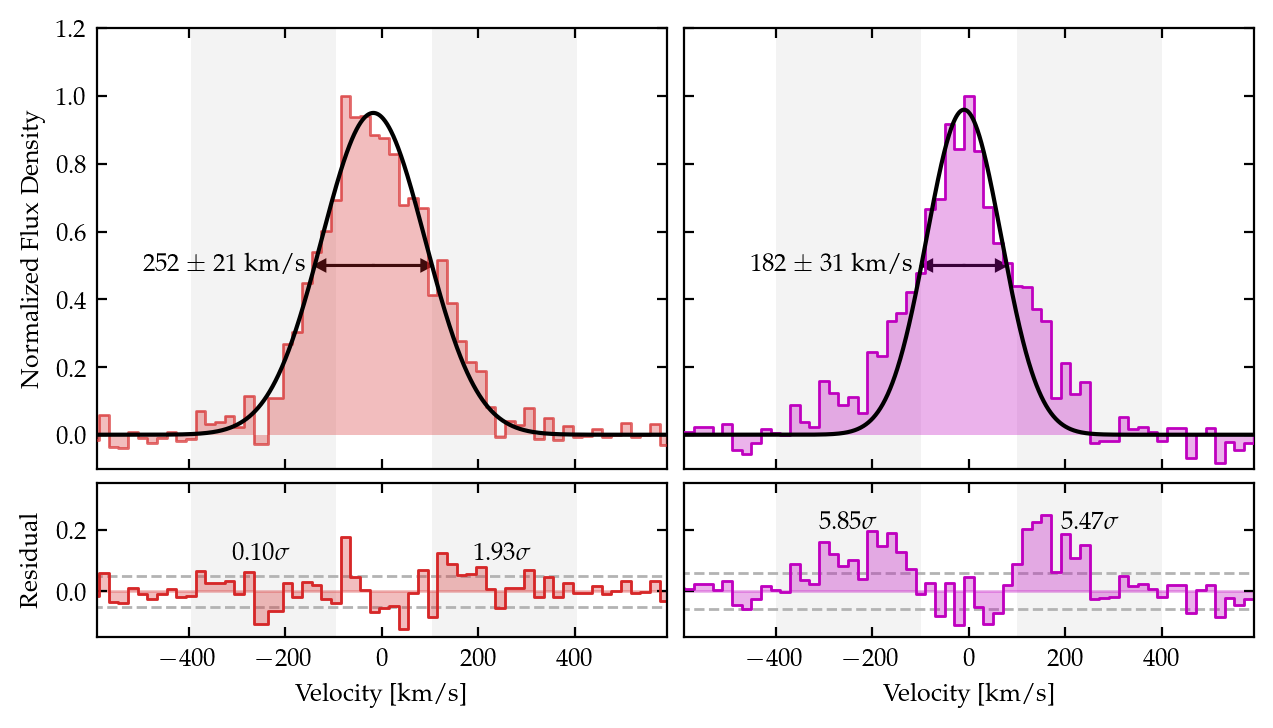

In [205]:

from base import *
x_vel = np.arange(-600,600,1)

fig = plt.figure(figsize=(6.5,3.5), constrained_layout=False)
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,0.35])
gs.update(left=0.1, right=0.99, top=0.98, bottom=0.11, hspace=0.05, wspace=0.03)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax = [ax0,ax1]

im = image('CII','cube','natural_uv0.3')
nu, flux, flux_err = im.Spectrum(ap, restfreq=233.687)

nu[27] = np.nan
flux = flux[~np.isnan(nu)]
flux_err = flux_err[~np.isnan(nu)]
nu = nu[~np.isnan(nu)]
flux_err /= np.max(flux)
flux /= np.max(flux)
std = np.median(flux_err)

### plot data
ax[0].step(nu, flux, color='tab:red', linewidth=1, alpha=0.7, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='tab:red', alpha=0.3, zorder=100)

### fit single gaussian
FWHM, FWHM_err = calc_FWHM_err(nu,flux, flux_err, N=5000)
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[1,0])
ax[0].plot(x_vel, gauss(x_vel, *coeff), color='k', zorder=102)
res = flux - gauss(nu, *coeff)
ax[1].step(nu, res, color='tab:red', where='mid', linewidth=1)
ax[1].fill_between(nu, res, color='tab:red', step='mid', alpha=0.3)

ax[0].annotate(fr'{FWHM:.0f} $\pm$ {FWHM_err:.0f} km/s', (coeff[0]-FWHM/1.6, 0.5), ha='right', va='center')
ax[0].arrow(coeff[1], 0.5, -FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)
ax[0].arrow(coeff[1], 0.5, FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)

numin, numax = -400, -100
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S1, N1 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S1/N1:.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (-250,2*std), ha='center')

numin, numax = 100, 400
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S2, N2 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S2/N2:.2f}')
print(f'Combined, wing residual shows S/N of {(S1+S2)/np.sqrt(N1**2+N2**2):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (250,2*std), ha='center')

ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-590,590)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-590,590)
ax[1].set_ylim(-4*std, 6*std)
ax[1].set_xlabel('Velocity [km/s]')
ax[0].set_ylabel('Normalized Flux Density')
ax[1].set_ylabel('Residual')
# ax[0].annotate(r'$[{\rm C}\,\textsc{ii}]~158~\mu$m', (0.05,0.95), xycoords='axes fraction', va='top', fontsize=11)
leg._legend_box.align = "left"
leg.get_title().set_fontsize('11')
ax[0].tick_params(direction='in', which='both', labelbottom=False)
ax[1].tick_params(direction='in', which='both')
ax[1].set_ylim(-0.15, 0.35)


ax0 = plt.subplot(gs[0,1])
ax1 = plt.subplot(gs[1,1])
ax = [ax0,ax1]

im = image('OIII','cube','natural_uv0')
nu, flux, flux_err = im.Spectrum(ap, restfreq=417.2)

flux_err /= np.max(flux)
flux /= np.max(flux)
std = np.median(flux_err)

### plot data
ax[0].step(nu, flux, color='m', linewidth=1, where='mid', zorder=101)
ax[0].fill_between(nu, flux,step='mid', fc='m', alpha=0.3, zorder=100)

### fit single gaussian
FWHM, FWHM_err = calc_FWHM_err(nu,flux, flux_err, N=5000)
coeff, var_matrix = curve_fit(gauss, nu, flux, p0=[1,0])
ax[0].plot(x_vel, gauss(x_vel,* coeff), color='k', zorder=102)
res = flux - gauss(nu, *coeff)
ax[1].step(nu, res, color='m', where='mid', linewidth=1)
ax[1].fill_between(nu, res, color='m', step='mid', alpha=0.3)

ax[0].annotate(fr'{FWHM:.0f} $\pm$ {FWHM_err:.0f} km/s', (coeff[0]-FWHM/1.6, 0.5), ha='right', va='center')
ax[0].arrow(coeff[1], 0.5, -FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)
ax[0].arrow(coeff[1], 0.5, FWHM/2.1, 0, head_width=0.03, head_length=20, fc='k', ec='k', length_includes_head=True)

numin, numax = -400, -100
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S1, N1 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S1/N1:.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (-250,3.5*std), ha='center')

numin, numax = 100, 400
imin, imax = np.argmin(np.abs(nu-numin)), np.argmin(np.abs(nu-numax))+1
ax[0].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
ax[1].fill_between([nu[imin],nu[imax-1]], [-1,-1],[100,100],ec='none', fc='0.7', alpha=0.15, zorder=-10)
S2, N2 = np.sum(res[imin:imax]), std*np.sqrt(imax-imin)
print(f'From nu = {nu[imin]:.1f} to nu = {nu[imax-1]:.1f}, single gaussian residual shows S/N of {S2/N2:.2f}')
print(f'Combined, wing residual shows S/N of {(S1+S2)/np.sqrt(N1**2+N2**2):.2f}')
ax[1].annotate(fr'{np.sum(res[imin:imax])/(std*np.sqrt(imax-imin)):.2f}$\sigma$', (250,3.5*std), ha='center')


ax[1].plot([-600,600],[std,std],zorder=-100,color='0.7',linestyle='--',linewidth=1)
ax[1].plot([-600,600],[-std,-std],zorder=-100,color='0.7',linestyle='--',linewidth=1)

ax[0].set_xlim(-590,590)
ax[0].set_ylim(-0.1*np.max(flux), 1.2*np.max(flux))
ax[1].set_xlim(-590,590)
ax[1].set_ylim(-0.15, 0.35)
ax[1].set_xlabel('Velocity [km/s]')
# ax[0].annotate(r'$[{\rm O}\,\textsc{iii}]~88~\mu$m', (0.05,0.95), xycoords='axes fraction', va='top', fontsize=11)
ax[0].tick_params(direction='in', which='both', labelbottom=False, labelleft=False)
ax[1].tick_params(direction='in', which='both', labelleft=False)

# plt.savefig('line_profiles_fixedFWHM_present_3.pdf')
plt.show()